# Collaborators Whereabouts
Author: Sam Eriksen

Description: Notebook to read in collaboration list from google sheets and plot

In [1]:
import numpy as np
import pandas as pd
#import tqdm
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

Get author list information

In [2]:
spreadsheet_id = "1J-8ehKgEcpmssEZ_dGRIp5lRQCg6tDonYYG87Rv__4I"
sheet_id = "951549455"
sheet_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={sheet_id}"

df = pd.read_csv(sheet_url)

cut_down_df = df.loc[4:].dropna(subset=["Unnamed: 2"])

final_info = cut_down_df[["Unnamed: 47", "Unnamed: 43", "# considered (x-check)", "PRIMARY PAGE", "Unnamed: 3"]]

final_info.columns = ["Title", "Initials", "LastName", "University", "isAuthor"]

In [3]:
final_info

,Title,Initials,LastName,University,isAuthor
6,Faculty,B. J.,Mount,Black Hills State University,TRUE
7,Undergrad,A.,Rodriguez,Black Hills State University,FALSE
9,Grad Stud,L.,Korley,Brandeis University,FALSE
10,Faculty,B.,Penning,Brandeis University,FALSE
11,Post Doc,J.J.,Wang,Brandeis University,FALSE
...,...,...,...,...,...
832,Engineer,W. T.,Emmet,Yale University,FALSE
833,Technician,T. W.,Hurteau,Yale University,FALSE
834,Grad Stud,N. A.,Larsen,Yale University,FALSE
835,Grad Stud,B. P.,Tennyson,Yale University,FALSE


Get university address information

In [4]:
spreadsheet_id = "1J-8ehKgEcpmssEZ_dGRIp5lRQCg6tDonYYG87Rv__4I"
sheet_id = "1098381277"
sheet_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={sheet_id}"

df = pd.read_csv(sheet_url)

institutions = df[["SECONDARY PAGE", "Unnamed: 7"]]
institutions.columns = ["University", "Address"]
institutions = institutions.iloc[4:]
institutions = institutions.dropna(subset=['Address'])
institutions['Address'] = institutions['Address'].str.replace('GBR', 'UK')
institutions['Universities_FullName'] = institutions['University'] + ', ' + institutions['Address']
institutions['Short_Address'] = institutions['Address'].apply(lambda x: ', '.join(x.split(', ')[-2:]))
institutions['Corrected_Name'] = institutions['University'].apply(lambda x: x.split(' (')[0])
institutions['Start_Address'] = institutions['Address'].apply(lambda x: ', '.join(x.split(', ')[:2]))

Get Long and Lat

In [6]:
def get_latitude(location):
    try:
        return location.latitude
    except AttributeError:
        return None

def get_longitude(location):
    try:
        return location.longitude
    except AttributeError:
        return None
def correct_none(entry):
    long = None
    lat = None
    print(entry['Short_Address'])
    if 'Daejeon' in entry['Short_Address']:
        lat = 36.375394
        long = 127.384520
    elif '57754-1700' in entry['Short_Address']:
        lat = 44.345992
        long = -103.755154
    print(long)
    print(lat)
    return long, lat

In [7]:
# Initialize the geocoder
geolocator = Nominatim(user_agent="university_geocoder")
# To avoid hitting the service rate limits
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [8]:
institutions['location'] = institutions['University'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Corrected_Name'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Short_Address'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Address'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Start_Address'].apply(geocode)

In [9]:
institutions['longitude'] = institutions['location'].apply(get_longitude)
institutions['latitude'] = institutions['location'].apply(get_latitude)
institutions[['longitude', 'latitude']] = institutions.apply(lambda row: correct_none(row) if pd.isna(row['latitude']) else (row['longitude'], row['latitude']), axis=1, result_type='expand')

Daejeon, KOR
127.38452
36.375394


In [10]:
institutions

,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude
4,Black Hills State University,"School of Natural Sciences, 1200 University St...","Black Hills State University, School of Natura...","SD 57799-0002, USA",Black Hills State University,"School of Natural Sciences, 1200 University St...","(Black Hills State University, 1200, Universit...",-103.872854,44.498150
5,Brookhaven National Laboratory (BNL),"P.O. Box 5000, Upton, NY 11973-5000, USA","Brookhaven National Laboratory (BNL), P.O. Box...","NY 11973-5000, USA",Brookhaven National Laboratory,"P.O. Box 5000, Upton","(BNL Police, Upton Road, Brookhaven National L...",-72.887100,40.864767
6,Brandeis University,"Department of Physics, 415 South Street, Walt...","Brandeis University, Department of Physics, 4...","MA 02453, USA",Brandeis University,"Department of Physics, 415 South Street","(Brandeis University, 415, South Street, West ...",-71.258020,42.366509
7,Brown University,"Department of Physics, 182 Hope Street, Provid...","Brown University, Department of Physics, 182 H...","RI 02912-9037, USA",Brown University,"Department of Physics, 182 Hope Street","(Brown University, Eddy Street, Downtown, Prov...",-71.408801,41.818640
8,Center for Underground Physics (CUP),"IBS Center for Underground Physics 70, Yuseong...","Center for Underground Physics (CUP), IBS Cent...","Daejeon, KOR",Center for Underground Physics,"IBS Center for Underground Physics 70, Yuseong...",None,127.384520,36.375394
9,Fermi National Accelerator Laboratory (FNAL),"P.O. Box 500, Batavia, IL 60510-5011, USA","Fermi National Accelerator Laboratory (FNAL), ...","IL 60510-5011, USA",Fermi National Accelerator Laboratory,"P.O. Box 500, Batavia","(Fermi National Accelerator Laboratory, Wilson...",-88.245782,41.842258
10,Imperial College London,"Physics Department, Blackett Laboratory, Londo...","Imperial College London, Physics Department, B...","London SW7 2AZ, UK",Imperial College London,"Physics Department, Blackett Laboratory","(Imperial College London, Exhibition Road, Kni...",-0.175641,51.498959
11,Kavli Institute for Particle Astrophysics and ...,"452 Lomita Mall, Stanford, CA 94305-4085 USA",Kavli Institute for Particle Astrophysics and ...,"Stanford, CA 94305-4085 USA",Kavli Institute for Particle Astrophysics and ...,"452 Lomita Mall, Stanford",(Stanford Institute for Economic Policy Resear...,-122.165508,37.429182
12,Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra, ...",Laboratório de Instrumentação e Física Experim...,"Coimbra, Portugal",Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra",(LIP - Laboratório de Instrumentação e Física ...,-9.143368,38.739920
13,Lawrence Berkeley National Laboratory (LBNL),"1 Cyclotron Road, Berkeley, CA 94720-8099, USA","Lawrence Berkeley National Laboratory (LBNL), ...","CA 94720-8099, USA",Lawrence Berkeley National Laboratory,"1 Cyclotron Road, Berkeley","(Lawrence Berkeley National Laboratory, Centen...",-122.245630,37.876959


Plot on a map all universities involved

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

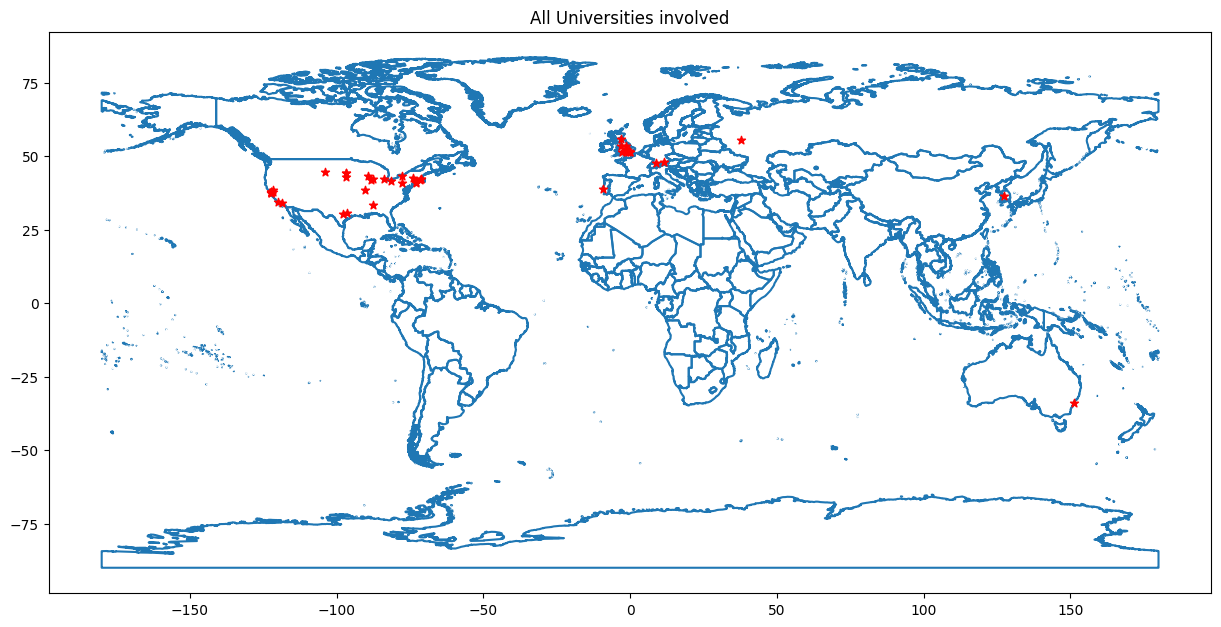

In [39]:
world = gpd.read_file('/home/sam/lz/shps/10m_cultural/ne_10m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(institutions['longitude'],institutions['latitude'], marker='*', color='red', zorder=2)

ax.set_title('All Universities involved')
plt.show()

In [36]:
author_universities = final_info.loc[final_info['isAuthor'] == 'TRUE', 'University'].unique()
author_university_locations = institutions[institutions['University'].isin(author_universities)]

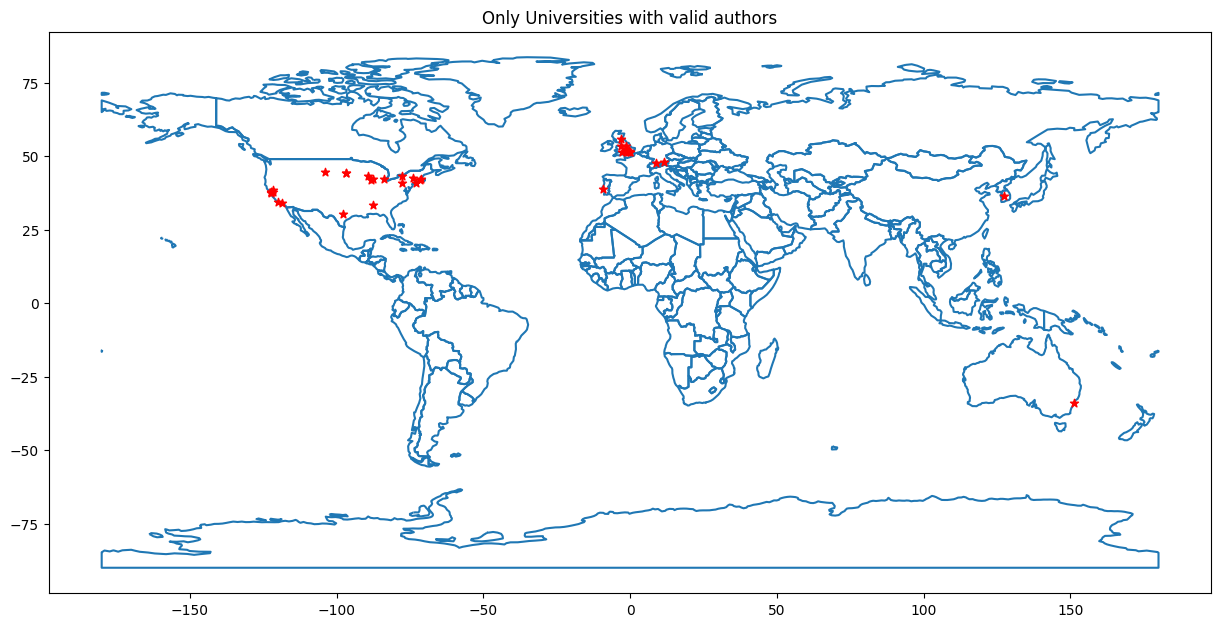

In [49]:
world = gpd.read_file('/home/sam/lz/shps/110m_cultural/ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(author_university_locations['longitude'],author_university_locations['latitude'], marker='*', color='red', zorder=2)

ax.set_title('Only Universities with valid authors')
plt.show()

Turn into density map

In [84]:
def get_country_or_state(location):
    if 'United States' in location.address:
        # Extract the state from the raw address information
        binning_region = location.raw['address'].get('state', '')
    else:
        # Use the last element of the address for the country
        binning_region = location.address.split(', ')[-1]
    return binning_region

In [85]:
# Calculate number of authors at each university
authors = final_info.loc[final_info['isAuthor'] == 'TRUE']
author_counts = authors['University'].value_counts()
author_university_locations["author_count"] = institutions['University'].map(author_counts)

# Create binning based on either country or state
author_university_locations['Binning1'] = author_university_locations['location'].apply(lambda loc: get_country_or_state(loc) if loc else None)

/tmp/ipykernel_1190/278926324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_university_locations["author_count"] = institutions['University'].map(author_counts)


AttributeError: 'Location' object has no attribute 'get'

In [75]:
for i in author_university_locations['location']:
    print(i)

Black Hills State University, 1200, University Street, West Addition, Ward 1, Spearfish, Lawrence County, South Dakota, 57799, United States
BNL Police, Upton Road, Brookhaven National Laboratory, Upton, Town of Brookhaven, Suffolk County, New York, 11973, United States
Brown University, Eddy Street, Downtown, Providence, Providence County, Rhode Island, 02912, United States
None
Fermi National Accelerator Laboratory, Wilson Street, Batavia, DuPage County, Illinois, United States
Imperial College London, Exhibition Road, Knightsbridge, London, Greater London, England, SW7 2AZ, United Kingdom
LIP - Laboratório de Instrumentação e Física Experimental de Partículas, 14, Avenida Elias Garcia, Campo Pequeno, Avenidas Novas, Lisboa, 1000-149, Portugal
Lawrence Berkeley National Laboratory, Centennial Drive, Oakland, Alameda County, California, 94720, United States
Lawrence Livermore National Laboratory, Sixth Street, Livermore, Alameda County, California, 94605, United States
Northwestern Un

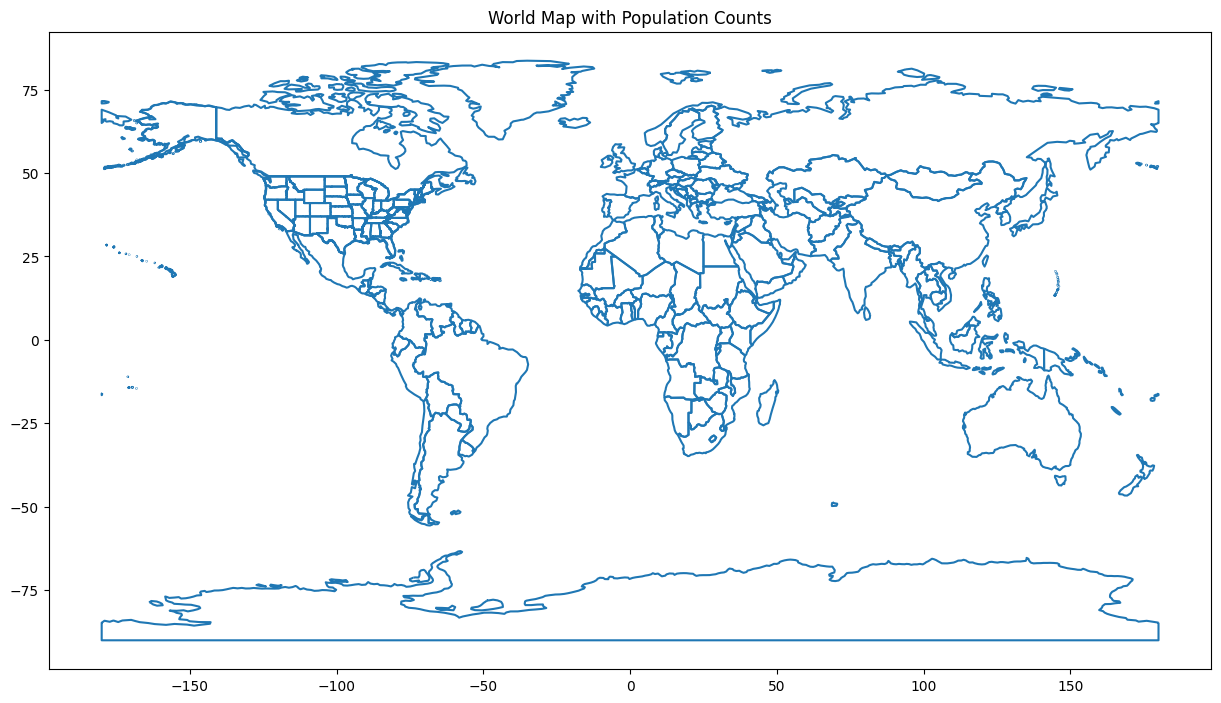

In [48]:
# Load your GeoDataFrames
world = gpd.read_file('/home/sam/lz/shps/110m_cultural/ne_110m_admin_0_countries.shp')
us_states = gpd.read_file('/home/sam/lz/shps/tl_2023_us_state/tl_2023_us_state.shp')


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, zorder=1) 
us_states.boundary.plot(ax=ax)
plt.title('World Map with Population Counts')
plt.show()

In [ ]:
# Load your GeoDataFrames
world = gpd.read_file('../shps/10m_cultural/ne_110m_admin_0_countries.shp')
us_states = gpd.read_file('/home/sam/lz/shps/tl_2023_us_state/tl_2023_us_state.shp')

# Merge the GeoDataFrames
world_merged = world.merge(location_counts, how='left', left_on='ADMIN', right_on='Bin_Region')

# Fill NaN values with 0
world_merged['count'] = world_merged['count'].fillna(0)

# Define a colormap where the lowest value (0) is white and the rest are colored
cmap = plt.get_cmap('viridis')
cmap = mcolors.ListedColormap(['white'] + [cmap(i) for i in range(cmap.N)])

# Normalize data to ensure non-zero values pop more
norm = mcolors.Normalize(vmin=0, vmax=world_merged['count'].max())

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the sea (countries with NaN values)
world.boundary.plot(ax=ax, color='lightblue')  # Set the sea color

# Plot the world map with the colormap
world_merged.plot(column='count', cmap=cmap, norm=norm, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Add a legend with a distinct color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Count')

# Show plot
plt.title('World Map with Population Counts')
plt.show()